# Support Vector Machines - team Euler

In [181]:
from toepassing_procedures import *
import numpy as np
# data inladen
import pandas as pd
from pandas import read_csv
# grafieken
from matplotlib import pyplot as plt
from matplotlib import rc

from sklearn.datasets import load_breast_cancer

### Toegepast op de tumordata

In [182]:
# We laden de data
gegevens = read_csv('breast_cancer.csv').sample(n=100)

# verander 0 in -1 en laat 1 staan
gegevens['diagnose'] = gegevens['diagnose'].replace(0, -1)

In [183]:
print(gegevens.columns)

Index(['diagnose', 'mean radius', 'mean texture', 'mean perimeter',
       'mean area', 'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')


In [184]:
diagnoses = gegevens['diagnose'].values

print(len(diagnoses))

100


In [185]:
data = gegevens.drop(['diagnose'], axis=1)

print(data)

     mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
375       16.170         16.07          106.30      788.5          0.09880   
152        9.731         15.34           63.78      300.2          0.10720   
53        18.220         18.70          120.30     1033.0          0.11480   
511       14.810         14.70           94.66      680.7          0.08472   
190       14.220         23.12           94.37      609.9          0.10750   
..           ...           ...             ...        ...              ...   
51        13.640         16.34           87.21      571.8          0.07685   
383       12.390         17.48           80.64      462.9          0.10420   
238       14.220         27.85           92.55      623.9          0.08223   
26        14.580         21.53           97.41      644.8          0.10540   
463       11.600         18.36           73.88      412.7          0.08508   

     mean compactness  mean concavity  mean concave points  mea

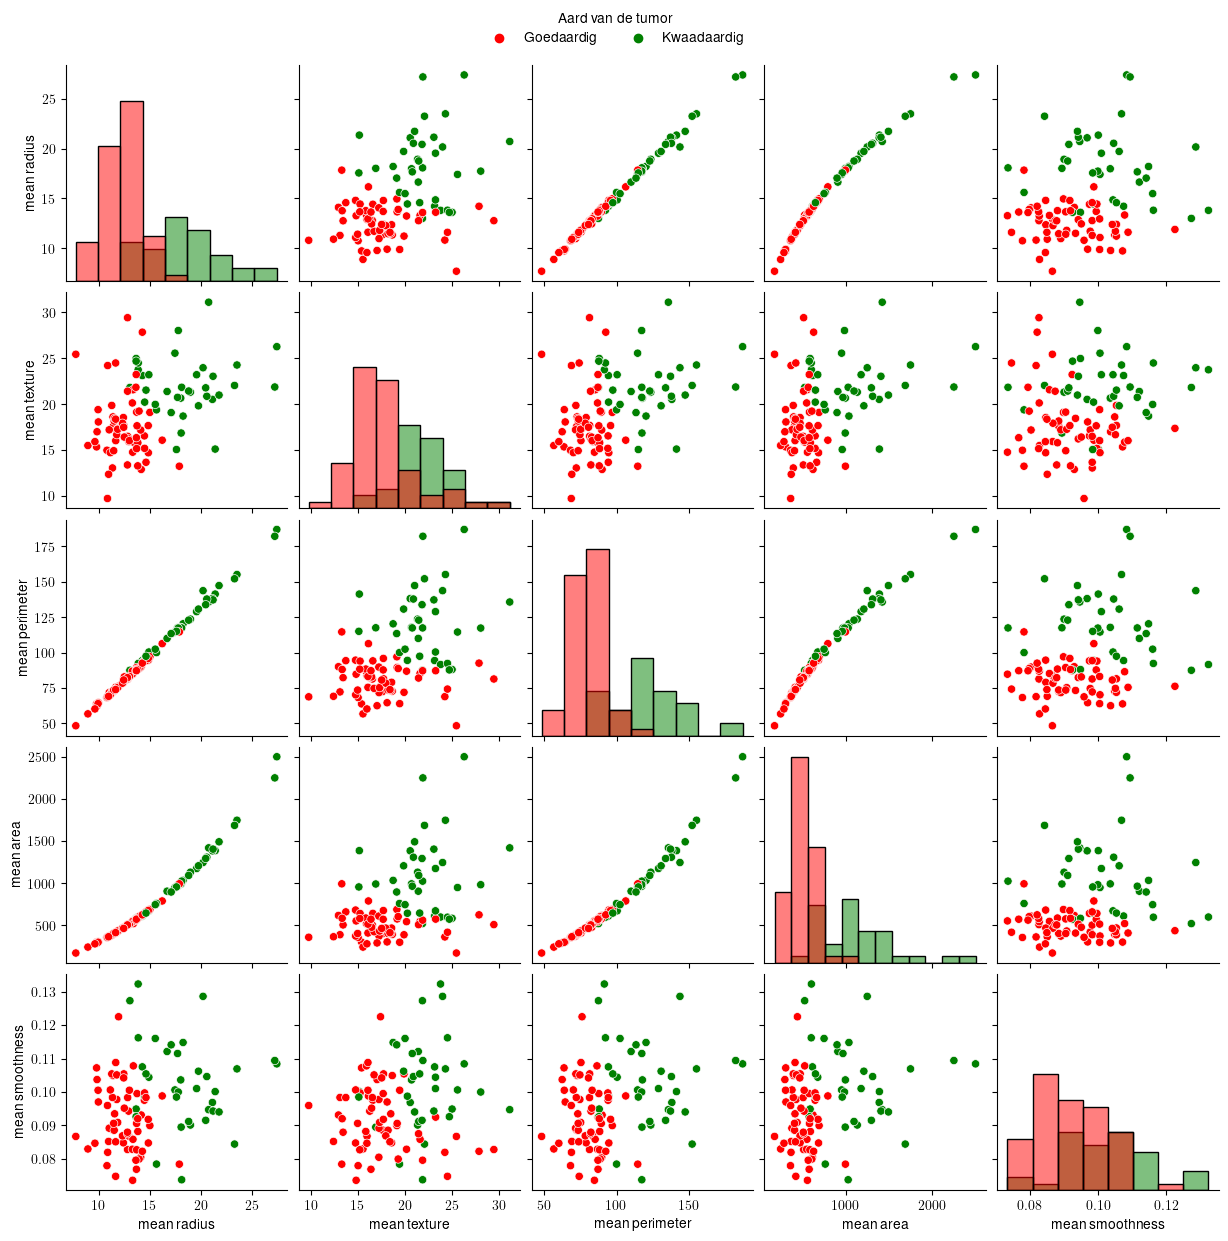

In [186]:
import seaborn as sns

diagnosesInWoorden = gegevens.copy()
diagnosesInWoorden['diagnose'] = gegevens['diagnose'].map({-1: 'Kwaadaardig', 1: 'Goedaardig'})

# we doen een sns pairplot met de eerste 5 features in de kleuren groen en rood
# 1 = goedaardig in de legende, 0 = kwaadaardig
pp = sns.pairplot(diagnosesInWoorden,vars=diagnosesInWoorden.columns[1:6], hue="diagnose", palette=["r","g"], height=2.5,diag_kind="hist")

handles = pp._legend_data.values()
labels = pp._legend_data.keys()

# pp.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=2)


sns.move_legend(pp, "upper center",title='Aard van de tumor', ncols=2)
pp.fig.subplots_adjust(top=0.95, bottom=0.05)

# schrijf de plot naar een bestand
plt.savefig('pairplot.pdf')

In [187]:

feature1 = 'mean texture'
feature2 = 'mean radius'

featureIndices = [gegevens.columns.get_loc(feature1), gegevens.columns.get_loc(feature2)]

X = gegevens.iloc[:, featureIndices].values
y = gegevens.iloc[:, 0].values

print(X)
print(y)

[[16.07  16.17 ]
 [15.34   9.731]
 [18.7   18.22 ]
 [14.7   14.81 ]
 [23.12  14.22 ]
 [15.1   21.37 ]
 [23.75  13.81 ]
 [18.61  11.34 ]
 [20.52  21.1  ]
 [16.54  14.42 ]
 [31.12  20.73 ]
 [18.06   9.904]
 [15.92  12.9  ]
 [12.88  14.11 ]
 [20.22  14.45 ]
 [24.21  10.82 ]
 [21.38  16.65 ]
 [23.23  13.62 ]
 [17.57  11.36 ]
 [17.19  11.71 ]
 [23.21  14.86 ]
 [23.04  21.16 ]
 [14.97  10.75 ]
 [24.27  23.51 ]
 [16.49  12.78 ]
 [15.49   8.878]
 [16.85  18.03 ]
 [25.56  17.42 ]
 [15.86  13.34 ]
 [17.2   10.97 ]
 [19.1   14.96 ]
 [29.43  12.77 ]
 [17.36  11.89 ]
 [19.38  15.61 ]
 [14.76  13.27 ]
 [16.02  11.61 ]
 [26.27  27.42 ]
 [17.18  14.06 ]
 [19.86  11.22 ]
 [24.49  13.82 ]
 [13.04  11.29 ]
 [16.99   9.777]
 [24.98  13.61 ]
 [20.66  17.99 ]
 [17.64  13.7  ]
 [21.82  13.   ]
 [24.69  13.61 ]
 [24.49  11.6  ]
 [17.68  12.4  ]
 [18.16  11.46 ]
 [15.18  14.44 ]
 [15.79  13.78 ]
 [19.13  13.66 ]
 [16.67  11.71 ]
 [16.21  12.87 ]
 [21.84  18.08 ]
 [22.04  23.27 ]
 [18.45  11.5  ]
 [21.57  13.3 

In [188]:
# splits in 50% train, 25% validatie en 25% test
trainingX, testX, trainingY, testY = train_test_split(X, y, test_size=0.25)
trainingX, validatieX, trainingY, validatieY = train_test_split(trainingX, trainingY, test_size=0.33)

print(trainingX.shape)
print(validatieX.shape)
print(testX.shape)

(50, 2)
(25, 2)
(25, 2)


We bepalen de beste waare voor $\lambda$ en evalueren de accuraatheid

In [189]:
# we bepalen de optimale regulairisatieparameter lambda
mogelijkeLambdas = np.linspace(0.0001, 8, 100)
leerTempo = 0.001
aantalIteraties = 1000

accuraatheden = []

for lambdaParam in mogelijkeLambdas:
    w, b = fit(trainingX, trainingY, leerTempo, lambdaParam, aantalIteraties)
    voorsp = voorspelling(validatieX, w, b)
    accuraatheden.append(accuraatheid(voorsp, validatieY))

besteLambda = mogelijkeLambdas[accuraatheden.index(max(accuraatheden))]
print(f"De beste lambda is {besteLambda}")
print(f"De accuraatheid bij deze lambda is {max(accuraatheden)}")

# we plotten de accurraatheid tegen de lambda
plt.figure()

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

plt.plot(mogelijkeLambdas, accuraatheden)
plt.scatter(besteLambda, max(accuraatheden), color='red', label="$\lambda_{opt}$: %.3f"%besteLambda, zorder=10)
plt.xlabel('Regularisatieparameter $\lambda$')
plt.ylabel('Accuraatheid op de validatiedata (\%)')
plt.legend()
plt.savefig('accuraatheid.pdf')

Het model toegepast op de testdata met $\lambda=\lambda_\text{opt}$

In [190]:
lambdaOpt = besteLambda
leerTempo = 0.001
aantalIteraties = 1000

print(lambdaOpt)

# we trainen het model met de optimale lambda
w, b = fit(trainingX, trainingY, leerTempo, lambdaOpt, aantalIteraties)

voorsp = voorspelling(testX, w, b)

print(accuraatheid(voorsp, testY))
truePositives = [testX[i] for i in range(len(testX)) if voorsp[i] == 1 and testY[i] == 1]
falsePositives = [testX[i] for i in range(len(testX)) if voorsp[i] == 1 and testY[i] == -1]
trueNegatives = [testX[i] for i in range(len(testX)) if voorsp[i] == -1 and testY[i] == -1]
falseNegatives = [testX[i] for i in range(len(testX)) if voorsp[i] == -1 and testY[i] == 1]

fig = plt.figure(figsize=(10, 10))

rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

ax = fig.add_subplot(1, 1, 1)

plt.scatter([p[0] for p in truePositives], [p[1] for p in truePositives], marker="o", c="g", label="Goedaardig, geclassificeerd als 'goedaardig'")
plt.scatter([p[0] for p in falseNegatives], [p[1] for p in falseNegatives], marker="x", c="g", label="Goedaardig, geclassificeerd als 'kwaadaardig'")
plt.scatter([p[0] for p in trueNegatives], [p[1] for p in trueNegatives], marker="o", c="r", label="Kwaadaardig, geclassificeerd als 'kwaadaardig'")
plt.scatter([p[0] for p in falsePositives], [p[1] for p in falsePositives], marker="x", c="r", label="Kwaadaardig, geclassificeerd als 'goedaaridg'")

x0_1 = min(testX[:, 0])
x0_2 = max(testX[:, 0])

x1_1 = hyperplaneFunctie(x0_1, w, b, 0)
x1_2 = hyperplaneFunctie(x0_2, w, b, 0)

x1_1_m = hyperplaneFunctie(x0_1, w, b, -1)
x1_2_m = hyperplaneFunctie(x0_2, w, b, -1)

x1_1_p = hyperplaneFunctie(x0_1, w, b, 1)
x1_2_p = hyperplaneFunctie(x0_2, w, b, 1)

ax.set_xlabel(feature1)
ax.set_ylabel(feature2)

ax.plot([x0_1, x0_2], [x1_1, x1_2], "k", label="Beslissingsgrens")
ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k--", label=r"Hypervlak met vergelijking $\vec{w}\cdot\vec{x} - b = 1$")
ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k--", label=r"Hypervlak met vergelijking $\vec{w}\cdot\vec{x} - b = -1$")

x1_min = np.amin(testX[:, 1])
x1_max = np.amax(testX[:, 1])
ax.set_ylim([x1_min - 3, x1_max + 3])

plt.legend()
plt.savefig("testdata.pdf")
plt.show()

We plotten het model voor 9 waarden van $\lambda$

In [191]:
# 9 waarden voor lambda
mogelijkeLambdas = np.linspace(0.0001, 3, 9)

leerTempo = 0.001
aantalIteraties = 10000

fig = plt.figure(figsize=(20, 20))

for i, lambdaParam in enumerate(mogelijkeLambdas):

    w, b = fit(trainingX, trainingY, leerTempo, lambdaParam, aantalIteraties)
    voorsp = voorspelling(trainingX, w, b)

    truePositives = [trainingX[i] for i in range(len(trainingX)) if voorsp[i] == 1 and trainingY[i] == 1]
    falsePositives = [trainingX[i] for i in range(len(trainingX)) if voorsp[i] == 1 and trainingY[i] == -1]
    trueNegatives = [trainingX[i] for i in range(len(trainingX)) if voorsp[i] == -1 and trainingY[i] == -1]
    falseNegatives = [trainingX[i] for i in range(len(trainingX)) if voorsp[i] == -1 and trainingY[i] == 1]

    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    rc('text', usetex=True)

    ax = fig.add_subplot(3, 3, i+1)

    ax.set_title(f"$\lambda =$ %.4f"%lambdaParam)

    plt.scatter([p[0] for p in truePositives], [p[1] for p in truePositives], marker="o", c="g")
    plt.scatter([p[0] for p in falsePositives], [p[1] for p in falsePositives], marker="x", c="r")
    plt.scatter([p[0] for p in trueNegatives], [p[1] for p in trueNegatives], marker="o", c="r")
    plt.scatter([p[0] for p in falseNegatives], [p[1] for p in falseNegatives], marker="x", c="g")

    x0_1 = min(trainingX[:, 0])
    x0_2 = max(trainingX[:, 0])

    x1_1 = hyperplaneFunctie(x0_1, w, b, 0)
    x1_2 = hyperplaneFunctie(x0_2, w, b, 0)

    x1_1_m = hyperplaneFunctie(x0_1, w, b, -1)
    x1_2_m = hyperplaneFunctie(x0_2, w, b, -1)

    x1_1_p = hyperplaneFunctie(x0_1, w, b, 1)
    x1_2_p = hyperplaneFunctie(x0_2, w, b, 1)

    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "k", label="Beslissingshypervlak")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k--", label=r"Hypervlak met vergelijking $\vec{w}\cdot\vec{x} - b = 1$")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k--", label=r"Hypervlak met vergelijking $\vec{w}\cdot\vec{x} - b = -1$")

    x1_min = np.amin(trainingX[:, 1])
    x1_max = np.amax(trainingX[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])


plt.savefig("9_waarden_voor_lambda_training.pdf", bbox_inches='tight', pad_inches=0)
plt.show()